# 7 Periodic Systems

## Exercise 36

### 4.1 Periodicity

import relevant class(es) from w5,
make a cluster,
implement periodicity (minimum image convention) from article from w5,
move the atomic cluster around and check that you get the same energy

In [631]:
# from clustering import HelloWorld
# import os
# print(os.listdir('//wsl.localhost/Ubuntu/home/justusperthes/repos/comPhys/Comphy/w4'))


a) Implement the periodicity in your simulation code. Use the minimum image convention as explained in the molecular dynamics article.

In [632]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist

class Atomic_Cluster:
    
    def __init__(self, data, color='C4'):
        # Check if data is a file path or an array
        if isinstance(data, str):
            self.positions = self.load_data(data)
        elif isinstance(data, np.ndarray):
            self.positions = data.reshape(-1, data.shape[1] // 2, 2)
        else:
            raise ValueError("Input must be a file path or a numpy array")
        
        self.color = color

    def load_data(self, data_file):
        # Load and reshape position data
        pos_flat = np.loadtxt(data_file)
        return pos_flat.reshape(-1, pos_flat.shape[1] // 2, 2)

    # Calculate mean and standard deviation of pairwise distances
    def descriptor(self, pos):
        all_distances = pdist(pos)
        mean = np.mean(all_distances)
        std = np.std(all_distances)
        return np.array([mean, std])
    
    # Draw both the atom configuration and the box
    def draw(self, pos, ax, box_size=10.0):
        # Scatter plot of atom positions (atom configuration)
        ax.scatter(pos[:, 0], pos[:, 1], color=self.color, s=200, label="Atoms")
        
        # Set limits to be slightly bigger than the box (2 units bigger on each side)
        ax.set_xlim(-1, box_size + 1)
        ax.set_ylim(-1, box_size + 1)
        
        # Draw the edges of the box
        rect = Rectangle((0, 0), box_size, box_size, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Set plot properties
        ax.set_title("Atom Configuration with Box Boundary")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')
        ax.grid(True)

    def plot_clusters(self, n_clusters=1, box_size=10.0):
        n_cols = 1  # Each cluster will use one column
        n_rows = n_clusters  # Number of clusters

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_clusters))

        # If there's only one cluster, axes will not be an array
        if n_clusters == 1:
            axes = [axes]  # Make it iterable

        for i in range(n_clusters):
            ax_scatter = axes[i]  # Access the axis
            self.draw(self.positions[i], ax_scatter, box_size=box_size)

        plt.tight_layout()
        plt.show()


Testing how extension of a class works (not really extending with anything useful)

Also plotting one or more cluster(s)

hellow, mamain


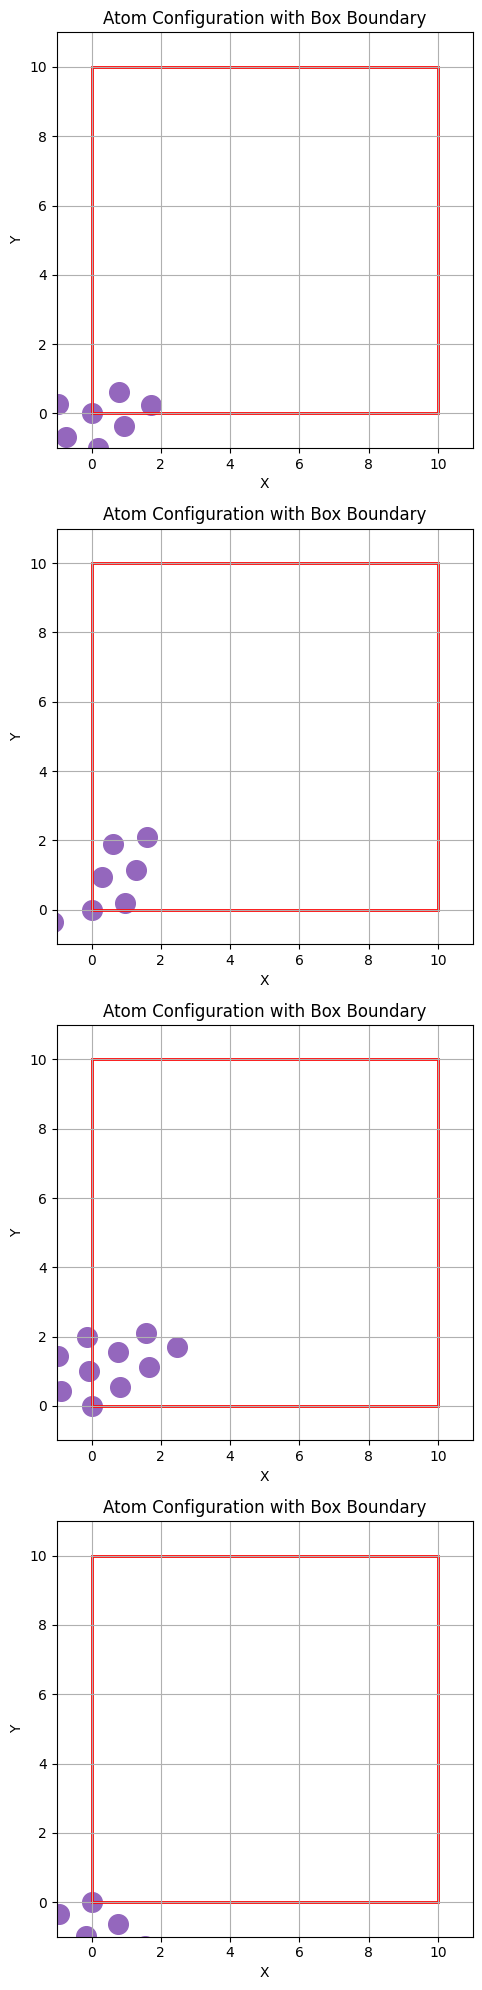

In [633]:
# extention of the relevant classes from above to incorporate periodicity

class Periodicity(Atomic_Cluster):
    ###
    def hellow_man(self):
        print("hellow, mamain")

data_file = 'lj10clusters.txt'  
period = Periodicity(data_file)

period.hellow_man()

n_clusters = 4
period.plot_clusters(n_clusters)

Implement periodicity into LennardJones. This is really cheating, since I am making a new class, not extending the old one - but whatever...

In [634]:
from scipy.spatial.distance import pdist,squareform


class PeriodicLennardJones():
    def __init__(self,eps=1):
        self.eps = eps
        
    def _V(self,r):
        return self.eps * (r**(-12) - 2 * r**(-6))

    def _dV_dr(self, r):
        return    self.eps * (-12 * r**(-13) + 12 * r**(-7) )
    
    # the following method is new compared to old LennardJones class:
    def _pairwise_distance_matrix(self, pos, box):
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
        for dim in range(2):  # Loop over x and y dimensions and get smallest component
            diff[..., dim] -= np.rint(diff[..., dim] / box[dim, dim]) * box[dim, dim]
        return diff
    
    def energy(self, pos, box):
        diff = self._pairwise_distance_matrix(pos, box)
        r = np.sqrt(np.sum(diff**2, axis=-1))
        return np.sum(self._V(squareform(r)))
    
    def forces(self, pos, box):
        diff = self._pairwise_distance_matrix(pos, box)
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, 1000)
        force_magnitude = self._dV_dr(r)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / \
                        r[..., np.newaxis], axis=1)
        return forces

In [635]:
import numpy as np

# Define a 2D box with size 10x10
box = np.array([[10.0, 0.0], [0.0, 10.0]])

# Define positions of 4 particles within the box
pos = np.array([
    [1.0, 1.0],
    [3.0, 4.0],
    [5.0, 5.0],
    [7.0, 2.0]
])

# Create an instance of the PeriodicLennardJones class
lj = PeriodicLennardJones(eps=1)

# Compute the potential energy of the system
energy = lj.energy(pos, box)
print(f"Potential Energy: {energy}")

# Compute the forces acting on each particle
forces = lj.forces(pos, box)
print("Forces:")
print(forces)


Potential Energy: -0.018474310609394903
Forces:
[[ 0.00031111  0.00144931]
 [ 0.03755284  0.01763653]
 [-0.03729865 -0.02035206]
 [-0.0005653   0.00126622]]


In [636]:
import matplotlib as plt

class PeriodicSystem():
    
    def __init__(self, calc, N=None, pos=None, static=None, box=None,
                descriptor_method=None, kT=0.15):
        self.calc = calc
        self.box = box
        assert (N is not None and pos is None) or \
               (N is None and pos is not None), 'You must specify either N or pos'
        if pos is not None:
            self.set_positions(np.array(pos)*1.)
            self.N = len(pos)
        else:
            self.N = N
            pos = np.random.rand(N,2)
            pos[:,0] *= self.box[0,0]
            pos[:,1] *= self.box[1,1]
            self.set_positions(pos)
        if static is not None:
            assert len(static) == self.N, 'static must be N long'
            self.static = static
        else:
            self.static = [False for _ in range(self.N)]
        self.filter = np.array([self.static,self.static]).T
        self.indices_dynamic_atoms = \
                            [i for i,static in enumerate(self.static) if not static]
        self.plot_artists = {}
        self.descriptor_method = descriptor_method
        self.kT = kT
        self.velocities = np.zeros(self.pos.shape)
        
    def copy(self):
        return PeriodicSystem(self.calc, pos=self.pos.copy(), static=self.static.copy(),
                              box=self.box.copy())

    def stress(self, delta=1e-4):
        return self.calc.stress(self.pos, self.box, delta=delta)
    
    def pressure(self, delta=1e-4):
        return self.calc.pressure(self.pos, self.box, delta=delta)
    
    @property
    def kinetic_energy(self):
        return 0.5 * np.sum(self.velocities**2)

    def set_velocities(self,velocities):
        self.velocities = np.where(self.filter,0,velocities)

    def get_velocities(self):
        return self.velocities.copy()
    
    def energy_title(self):
        return f'Ek={self.kinetic_energy:.1f} ' +\
               f'Ep={self.potential_energy:.1f} ' + \
               f'E={self.potential_energy + self.kinetic_energy:.1f}'
    
    @property
    def potential_energy(self):
        return self.calc.energy(self.pos,self.box)
        
    def forces(self):
        forces = self.calc.forces(self.pos,self.box)
        return np.where(self.filter,0,forces)
    
    def set_positions(self,pos):
        pos[:,0] = pos[:,0] % self.box[0,0]
        pos[:,1] = pos[:,1] % self.box[1,1]
        self.pos = pos
        
    def get_scaled_positions(self):
        return self.pos @ np.linalg.inv(self.box).T
        
    def get_positions(self):
        return self.pos.copy()
        
    def draw_periodic(self,ax,size=200):
        ax.scatter(self.pos[:,0],self.pos[:,1],s=size)
        for i, (x,y) in enumerate(self.pos):
            ax.text(x,y,str(i),ha='center',va='center',color='w')
        deltas = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        for dx,dy in deltas:
            ax.scatter(self.pos[:,0]+dx*self.box[0,0],self.pos[:,1]+dy*self.box[1,1],
                       s=size,facecolor='w',edgecolor='C0')
    def draw_cell(self,ax):        
        ax.plot(np.array([0,self.box[0,0],self.box[0,0],0,0]),
                np.array([0,0,self.box[1,1],self.box[1,1],0]))
        
    @property
    def descriptor(self):
        return self.descriptor_method.descriptor(self.pos)

    def energy_title(self):
        return f'Ep={self.potential_energy:.1f}'
    
    def draw(self,ax,size=100,alpha=1,force_draw=False,edge=False,color='C0',
             energy_title=True):
        if self.plot_artists.get(ax,None) is None or force_draw or edge:
            colors = ['C1' if s else color for s in self.static]
            facecolors = [plt.to_rgba(c,alpha) for c in colors]
            if edge:
                edgecolors = (0,0,0,1)
                self.plot_artists[ax] = ax.scatter(self.pos[:,0],self.pos[:,1],
                                               s=size,facecolors=facecolors,
                                                  edgecolors=edgecolors,
                                                  linewidth=2)
            else:
                edgecolors = (0,0,0,0.5)
                self.plot_artists[ax] = ax.scatter(self.pos[:,0],self.pos[:,1],
                                                   s=size,facecolors=facecolors,
                                                  edgecolors=edgecolors,)
        else:
            self.plot_artists[ax].set_offsets(self.pos)
        if energy_title:
            ax.set_title(self.energy_title())

    def draw_descriptor(self,ax):
        self.descriptor_method.draw(self.pos,ax)

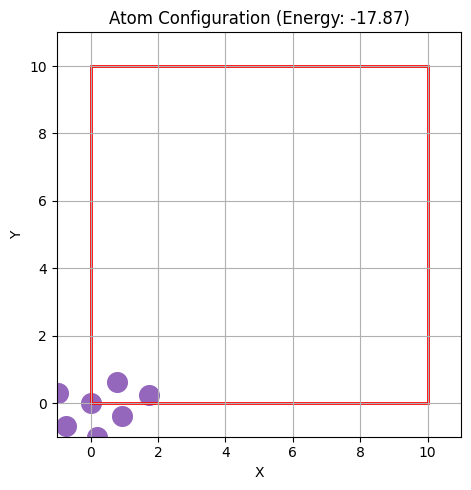

In [637]:
import matplotlib.pyplot as plt
# Usage example with the provided data file and a 10x10 box
data_file = 'lj10clusters.txt'
box = np.array([[10.0, 0.0], [0.0, 10.0]])

# Create instances of both classes
atomic_cluster = Atomic_Cluster(data_file)
lj = PeriodicLennardJones(eps=1)

# Define a function that computes the energy for each cluster and plots them
def plot_clusters_with_energy(atomic_cluster, lj, n_clusters, box):
    n_cols = 1
    n_rows = n_clusters
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_clusters))

    # If there's only one cluster, axes will not be an array, so make it iterable
    if n_clusters == 1:
        axes = [axes]

    for i in range(n_clusters):
        pos = atomic_cluster.positions[i]
        energy = lj.energy(pos, box)
        ax_scatter = axes[i]  # Access the axis
        atomic_cluster.draw(pos, ax_scatter)
        ax_scatter.set_title(f"Atom Configuration (Energy: {energy:.2f})")

    plt.tight_layout()
    plt.show()

# Assume we want to plot all clusters (e.g., 10 clusters)
n_clusters = 1
plot_clusters_with_energy(atomic_cluster, lj, n_clusters, box)

Initial Energy: -17.87
Shifted Energy: -17.87


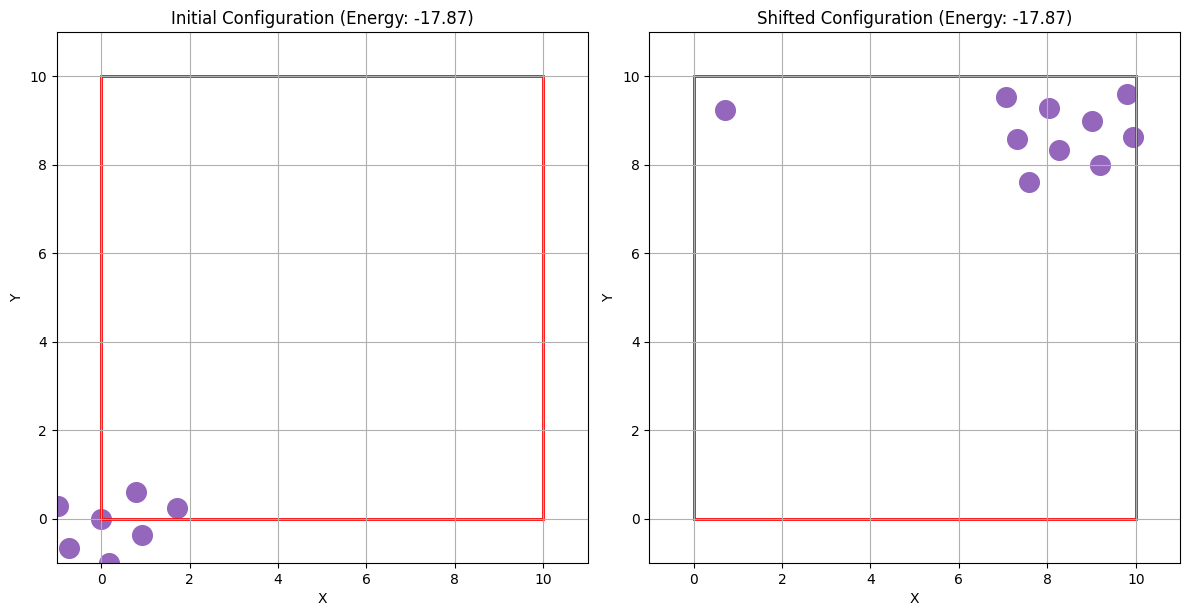

The energies are the same, showing that shifting the cluster does not change the energy due to periodic boundary conditions.


In [638]:
import numpy as np
import matplotlib.pyplot as plt

# Usage example with the provided data file and a 10x10 box
data_file = 'lj10clusters.txt'
box = np.array([[10.0, 0.0], [0.0, 10.0]])

# Create instances of both classes
atomic_cluster = Atomic_Cluster(data_file)
lj = PeriodicLennardJones(eps=1)

# Extract the first cluster
pos_initial = atomic_cluster.positions[0]

# Compute the initial energy
energy_initial = lj.energy(pos_initial, box)
print(f"Initial Energy: {energy_initial:.2f}")

# Shift the cluster to be very close to the box boundary, e.g., shift by 9 units
shift_vector = np.array([9.0, 9.0])
pos_shifted = pos_initial + shift_vector

# Apply periodic boundary conditions to wrap positions into the box
pos_shifted = pos_shifted % box[0, 0]

# Compute the energy after shifting
energy_shifted = lj.energy(pos_shifted, box)
print(f"Shifted Energy: {energy_shifted:.2f}")

# Plot both configurations for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot initial configuration
ax1 = axes[0]
atomic_cluster.draw(pos_initial, ax1)
ax1.set_title(f"Initial Configuration (Energy: {energy_initial:.2f})")

# Plot shifted configuration
ax2 = axes[1]
atomic_cluster.draw(pos_shifted, ax2)
ax2.set_title(f"Shifted Configuration (Energy: {energy_shifted:.2f})")

plt.tight_layout()
plt.show()

# Check if the energies are nearly identical
if np.isclose(energy_initial, energy_shifted):
    print("The energies are the same, showing that shifting the cluster does not change the energy due to periodic boundary conditions.")
else:
    print("The energies differ, which may indicate an issue with the periodic boundary condition handling.")


c) Setup a cell with N atoms in a periodic arrangement as a crystal. Duplicate the cell in both directions and place 4N atoms at positions so that the same system is modelled.

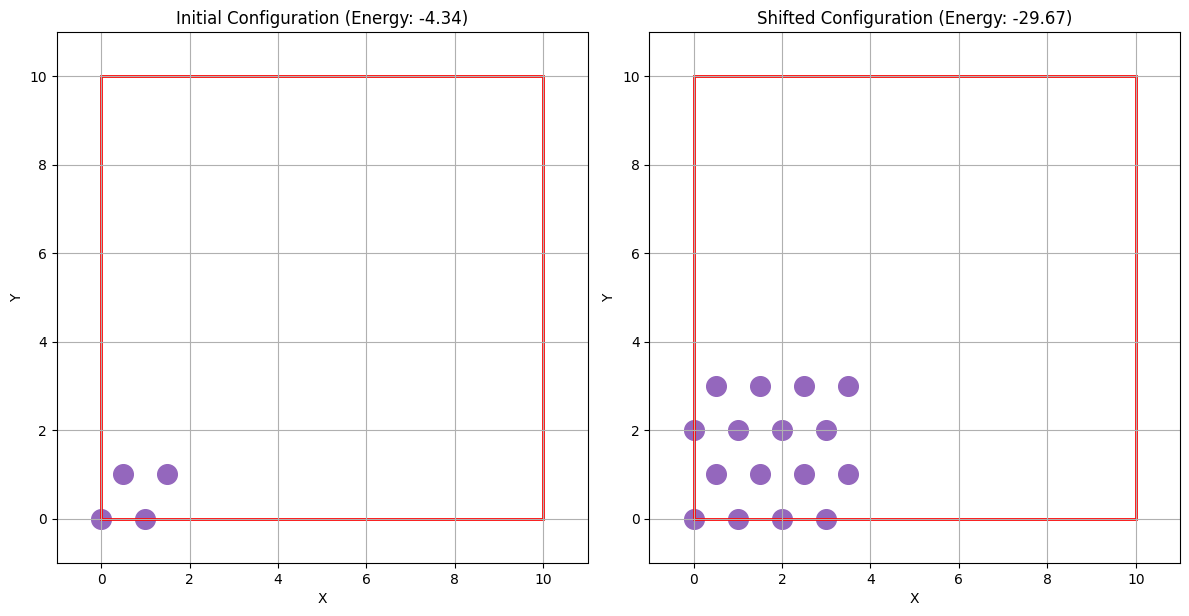

The energy is increased by a factor 6.831637131217758.


In [639]:
# Define a custom 2D atomic cluster
pos = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, 1.0],
    [1.5, 1.0]
])

# Define a 2D box with size 10x10
box = np.array([[10.0, 0.0], [0.0, 10.0]])

# Create an instance of the PeriodicLennardJones class
lj = PeriodicLennardJones(eps=1)

# Create an instance of the Atomic_Cluster class using the array directly
atomic_cluster = Atomic_Cluster(pos)

# Shift the position of the atomic cluster by moving it towards the edge of the box
shifted_pos1 = pos + np.array([2.0,0.0])
shifted_pos2 = pos + np.array([0.0,2.0])
shifted_pos3 = pos + np.array([2.0,2.0])
pos_extended = np.vstack([pos,shifted_pos1])
pos_extended = np.vstack([pos_extended,shifted_pos2])
pos_extended = np.vstack([pos_extended,shifted_pos3])

energy_initial = lj.energy(pos, box)

# Calculate the energy for the shifted configuration
energy_extended = lj.energy(pos_extended, box)

# Plot both configurations for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot initial configuration
ax1 = axes[0]
atomic_cluster.draw(pos, ax1, box_size=10.0)
ax1.set_title(f"Initial Configuration (Energy: {energy_initial:.2f})")

# Plot shifted configuration
ax2 = axes[1]
atomic_cluster.draw(pos_extended, ax2, box_size=10.0)
ax2.set_title(f"Shifted Configuration (Energy: {energy_extended:.2f})")

plt.tight_layout()
plt.show()

print(f"The energy is increased by a factor {energy_extended/energy_initial}.")


Why is the energy nost just increased by a factor 4?
...

d) Repeat for a larger system.

In [640]:
class Extended_Cluster(Atomic_Cluster):
    def extend_cluster(self, factor, duplicates):
        """Extend the atomic cluster by creating duplicates in x and y directions."""
        extended_positions = []
        for dx in range(-duplicates, duplicates + 1):
            for dy in range(-duplicates, duplicates + 1):
                # Skip the original position
                if dx == 0 and dy == 0:
                    continue
                shifted_positions = self.positions + np.array([dx * factor, dy * factor])
                extended_positions.append(shifted_positions)
        # Combine the original positions with the extended ones
        return np.vstack([self.positions] + extended_positions)

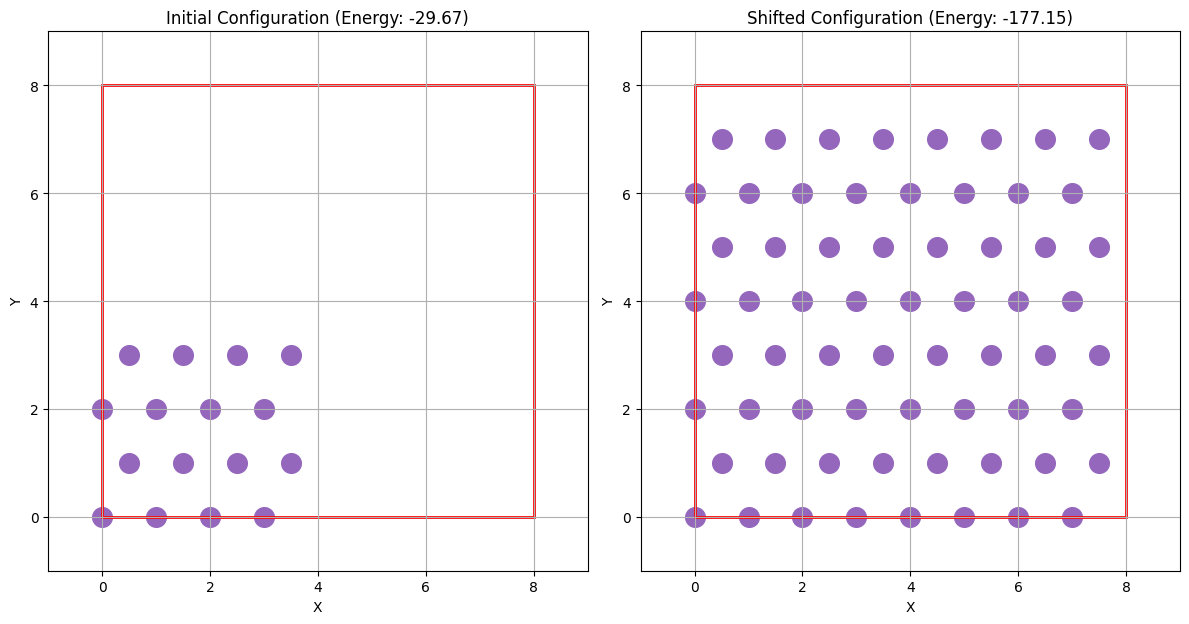

The energy is increased by a factor 5.970697619114381. The energy factor should approach 4.


In [641]:
# Define a custom 2D atomic cluster
pos_initial = pos_extended
pos = pos_extended

# Define a 2D box with size 10x10
box = np.array([[8.0, 0.0], [0.0, 8.0]])

# Create an instance of the PeriodicLennardJones class
lj = PeriodicLennardJones(eps=1)

# Create an instance of the Extended_Cluster class using the array directly
atomic_cluster = Extended_Cluster(pos)

# Shift the position of the atomic cluster by moving it towards the edge of the box
shifted_pos1 = pos + np.array([4.0,0.0])
shifted_pos2 = pos + np.array([0.0,4.0])
shifted_pos3 = pos + np.array([4.0,4.0])
# shifted_pos4 = pos + np.array([8.0,0.0])
# shifted_pos5 = pos + np.array([8.0,4.0])
# shifted_pos6 = pos + np.array([8.0,8.0])
# shifted_pos7 = pos + np.array([4.0,8.0])
# shifted_pos8 = pos + np.array([4.0,0.0])
pos_extended = np.vstack([pos,shifted_pos1])
pos_extended = np.vstack([pos_extended,shifted_pos2])
pos_extended = np.vstack([pos_extended,shifted_pos3])
# pos_extended = np.vstack([pos_extended,shifted_pos4])
# pos_extended = np.vstack([pos_extended,shifted_pos5])
# pos_extended = np.vstack([pos_extended,shifted_pos6])
# pos_extended = np.vstack([pos_extended,shifted_pos7])
# pos_extended = np.vstack([pos_extended,shifted_pos8])

energy_initial = lj.energy(pos_initial, box)

# Calculate the energy for the shifted configuration
energy_extended = lj.energy(pos_extended, box)

# Plot both configurations for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot initial configuration
ax1 = axes[0]
atomic_cluster.draw(pos, ax1, box_size=8.0)
ax1.set_title(f"Initial Configuration (Energy: {energy_initial:.2f})")

# Plot shifted configuration
ax2 = axes[1]
atomic_cluster.draw(pos_extended, ax2, box_size=8.0)
ax2.set_title(f"Shifted Configuration (Energy: {energy_extended:.2f})")

plt.tight_layout()
plt.show()

print(f"The energy is increased by a factor {energy_extended/energy_initial}. The energy factor should approach 4.")


### 4.4 Forces

e) Relax some of your systems under periodic boundary conditions and observe that the forces respect the periodic boundary conditions. 

E.g. if one atom is moved, then in the subsequent relaxation, it relaxes back.

It might be easier to plot or print the forces and see that they are correct compared to what you get with the non-periodic code you have been using up to now.

## Exercise 37: 
### 5.1 Thermal expansion
This exercise is about modeling the thermal expansion of a crystal that is heated up while allowed to expand.

a) Implement the stress and pressure evaluation. Test it on the perfect crystal structure you formed in the previous exercise. When you vary the volume around the equilibrium volume, the energy should go up and the sign of the pressure should be correct.

In [642]:
class StressPressureCalculator:
    def __init__(self, energy_function, box, volume, strain=1e-4):
        """
        Initialize the StressPressureCalculator.

        Parameters:
        - energy_function: Callable that calculates the total energy of the system.
        - box: Box size for the simulation.
        - volume: Volume of the system (or area in 2D).
        - strain: Small strain value for finite difference calculation (default: 1e-4).
        """
        self.energy_function = energy_function
        self.box = box
        self.volume = volume
        self.strain = strain

    def compute_stress(self, pos_extended):
        """
        Compute the stress tensor components using finite difference.

        Parameters:
        - pos_extended: Extended position array of the atoms.

        Returns:
        - sigma_xx, sigma_yy: Diagonal components of the stress tensor.
        """
        # Reference energy
        E0 = self.energy_function(pos_extended, self.box)

        # Apply strain in the x-direction
        box_x = np.copy(self.box)
        box_x[0] *= (1 + self.strain)  # Only strain in the x-direction
        E_xx = self.energy_function(pos_extended, box_x)
        sigma_xx = - (E_xx - E0) / (self.volume * self.strain)

        # Apply strain in the y-direction
        box_y = np.copy(self.box)
        box_y[1] *= (1 + self.strain)  # Only strain in the y-direction
        E_yy = self.energy_function(pos_extended, box_y)
        sigma_yy = - (E_yy - E0) / (self.volume * self.strain)

        return sigma_xx, sigma_yy

    def compute_pressure(self, pos_extended):
        """
        Compute the pressure using the stress tensor components.

        Parameters:
        - pos_extended: Extended position array of the atoms.

        Returns:
        - Pressure value.
        """
        sigma_xx, sigma_yy = self.compute_stress(pos_extended)
        pressure = 0.5 * (sigma_xx + sigma_yy)
        return pressure

# Assuming lj.energy(pos_extended, box) is defined
box = np.array([[8.0, 0.0], [0.0, 8.0]])  # Correct box size as 2x2 matrix
volume = np.linalg.det(box)  # Correct volume calculation for 2D
pos_extended = np.random.rand(19, 2) * box[0, 0]  # Example positions within the box

# Create the calculator object
calc = StressPressureCalculator(lj.energy, box, volume)

# Calculate pressure
pressure = calc.compute_pressure(pos_extended)
print(f"Pressure: {pressure}")



Pressure: -0.02792337909340859


Test by varyinh the volume.

Original Box Pressure: -3.354170902083453
Box scale: 0.7, Pressure: 1130.2342068753887, Volume: 7.839999999999998
Box scale: 1.0, Pressure: -3.354170902083453, Volume: 15.999999999999998
Box scale: 1.5, Pressure: -0.45601002084789183, Volume: 36.0
Box scale: 3.0, Pressure: -0.0019016106683230514, Volume: 144.0


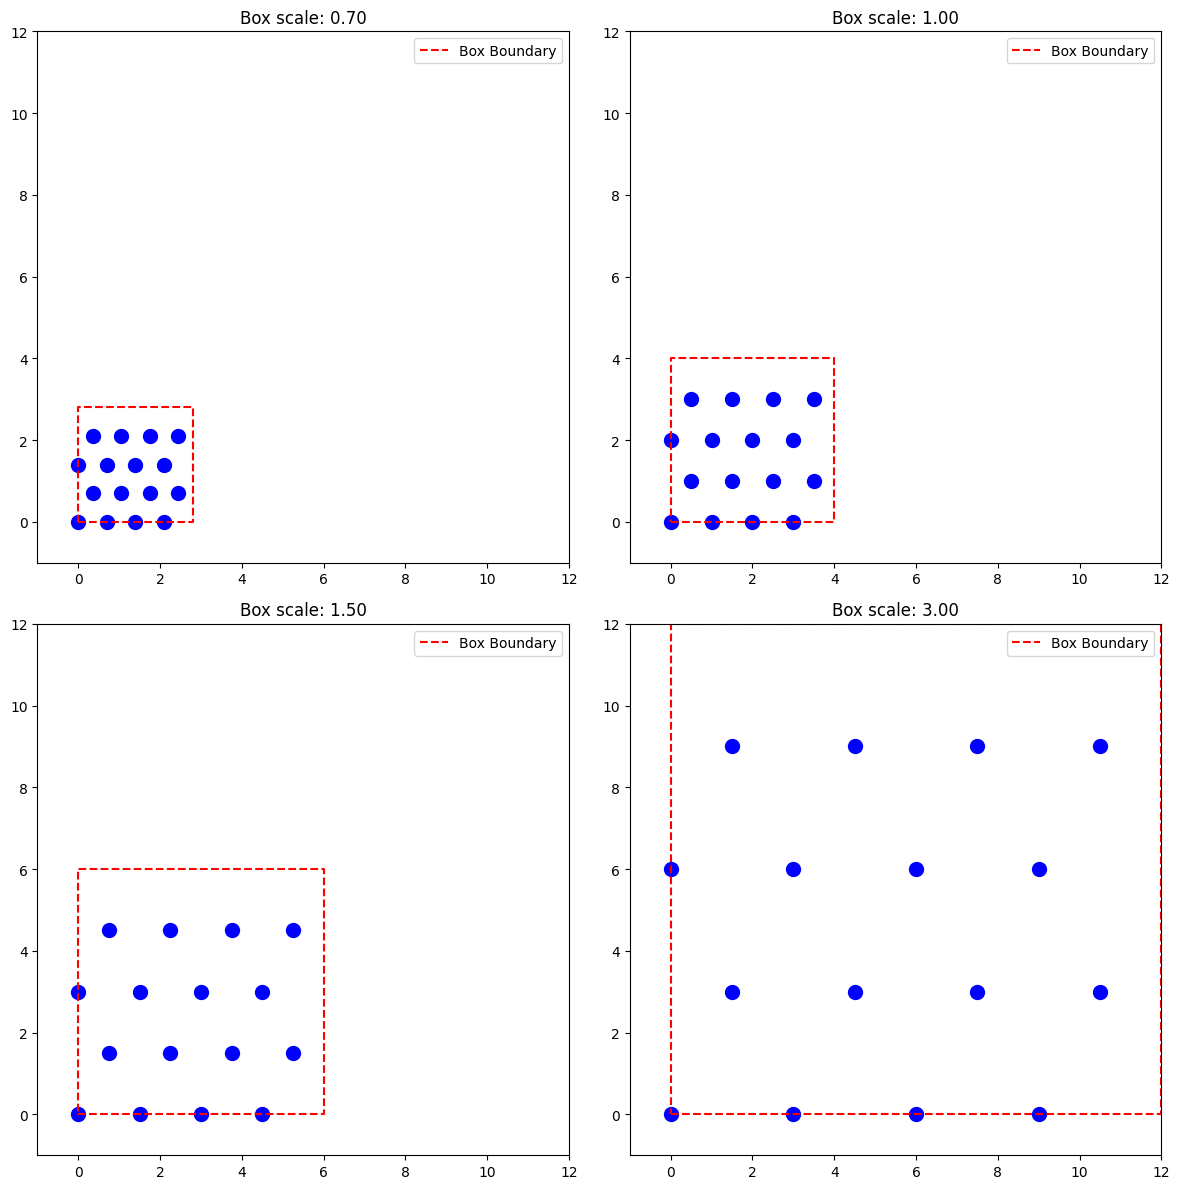

In [643]:
# Assuming lj.energy(pos_extended, box) is defined
box = np.array([[4.0, 0.0], [0.0, 4.0]])  # Correct box size as 2x2 matrix
volume = np.linalg.det(box)  # Correct volume calculation for 2D
# pos_extended = np.random.rand(19, 2) * box[0, 0]  # Example positions within the box
pos_extended = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, 1.0],
    [1.5, 1.0],
    [0.0, 2.0],
    [1.0, 2.0],
    [0.5, 3.0],
    [1.5, 3.0],
    [2.0, 0.0],
    [3.0, 0.0],
    [2.5, 1.0],
    [3.5, 1.0],
    [2.0, 2.0],
    [3.0, 2.0],
    [2.5, 3.0],
    [3.5, 3.0],

])

# Create the calculator object
calc = StressPressureCalculator(lj.energy, box, volume)

# Calculate pressure for the original box
pressure = calc.compute_pressure(pos_extended)
print(f"Original Box Pressure: {pressure}")

# Adjust the box size to observe changes in pressure
for scale in [0.7, 1.0, 1.5, 3.0]:
    # Correct way to scale the box dimensions
    test_box = np.array([[box[0, 0] * scale, 0.0], [0.0, box[1, 1] * scale]])
    test_volume = np.linalg.det(test_box)

    # Scale the atomic positions accordingly
    pos_scaled = pos_extended * scale

    # Create the calculator object with the scaled box
    calc = StressPressureCalculator(lj.energy, test_box, test_volume)

    # Calculate pressure
    pressure = calc.compute_pressure(pos_scaled)
    print(f"Box scale: {scale}, Pressure: {pressure}, Volume: {test_volume}")

# Original box size
box = np.array([[4.0, 0.0], [0.0, 4.0]])

# Different box scales
scales = [0.7, 1.0, 1.5, 3.0]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, scale in enumerate(scales):
    # Correctly scale the box
    test_box = np.array([[box[0, 0] * scale, 0.0], [0.0, box[1, 1] * scale]])
    # Scale the atomic positions accordingly
    pos_scaled = pos * scale

    # Plot the scaled positions
    ax = axes[i // 2, i % 2]
    ax.scatter(pos_scaled[:, 0], pos_scaled[:, 1], color='blue', s=100)
    ax.set_title(f"Box scale: {scale:.2f}")
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)
    ax.set_aspect('equal')

    # Draw the box outline
    ax.plot([0, test_box[0, 0], test_box[0, 0], 0, 0], 
            [0, 0, test_box[1, 1], test_box[1, 1], 0], 
            color='red', linestyle='--', label='Box Boundary')

    ax.legend()

plt.tight_layout()
plt.show()

The pressure from differences in stress is only valid in the linear regime, so the volume changes should be minimal. In the above they are quite large!

Visualize the pressure curve:

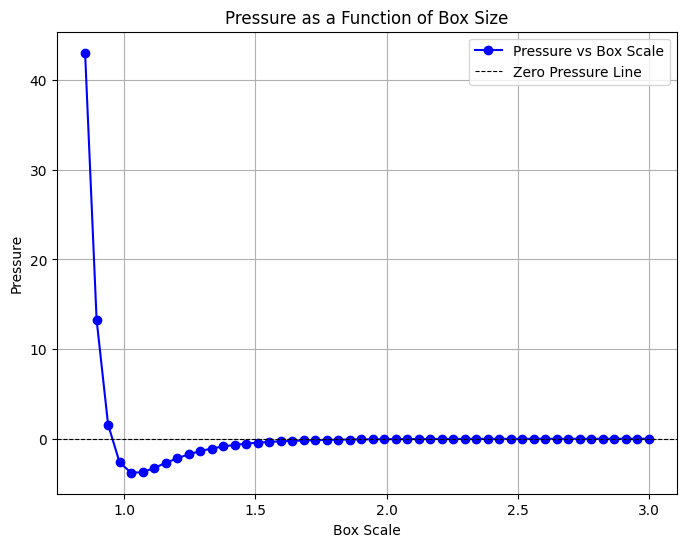

In [644]:
import numpy as np
import matplotlib.pyplot as plt

# Define the initial box size and atomic positions (ideal lattice configuration)
box = np.array([[4.0, 0.0], [0.0, 4.0]])
volume = np.linalg.det(box)
pos_extended = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, 1.0],
    [1.5, 1.0],
    [0.0, 2.0],
    [1.0, 2.0],
    [0.5, 3.0],
    [1.5, 3.0],
    [2.0, 0.0],
    [3.0, 0.0],
    [2.5, 1.0],
    [3.5, 1.0],
    [2.0, 2.0],
    [3.0, 2.0],
    [2.5, 3.0],
    [3.5, 3.0]
])

# Define the range of box scales to test (from strong compression to expansion)
scales = np.linspace(0.85, 3.0, 50)
pressures = []

# Calculate pressure for each box scale
for scale in scales:
    # Correct way to scale the box dimensions
    test_box = np.array([[box[0, 0] * scale, 0.0], [0.0, box[1, 1] * scale]])
    test_volume = np.linalg.det(test_box)
    # Scale the atomic positions accordingly
    pos_scaled = pos_extended * scale

    # Create the calculator object with the scaled box
    calc = StressPressureCalculator(lj.energy, test_box, test_volume)
    # Calculate pressure
    pressure = calc.compute_pressure(pos_scaled)
    pressures.append(pressure)

# Plotting the pressure as a function of box size
plt.figure(figsize=(8, 6))
plt.plot(scales, pressures, marker='o', linestyle='-', color='blue', label='Pressure vs Box Scale')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Pressure Line')
plt.xlabel('Box Scale')
plt.ylabel('Pressure')
plt.title('Pressure as a Function of Box Size')
plt.grid(True)
plt.legend()
plt.show()


The curve crosses the x-axies at slightly lower than box size 1.0 (which is an arbritrary value). So means that the equilibrium is around 0.9*box. This is where the pressure is zero. 

The minimum of the pressure curve represents the point where the negative pressure (tensile stress) is strongest.

This means the system is in a state of maximum tension, where the atoms are far enough apart to be strongly pulled towards each other.

After this point, the pressure becomes less negative, indicating that the attractive forces weaken as the atoms move even further apart.

b) Implement a p=0-barostat and test that it will bring the pressure to zero by adjusting the volume.

In [645]:
class Barostat:
    def __init__(self, calc, pos, box, target_pressure=0, tau_p=1, dt=0.001):
        """
        Implements a Berendsen barostat to maintain zero pressure.
        
        Parameters:
        - calc: StressPressureCalculator object.
        - pos: Initial atomic positions.
        - box: Initial simulation box.
        - target_pressure: Desired pressure (0 for this exercise).
        - tau_p: Relaxation time of the barostat.
        - dt: Time step for volume adjustment.
        """
        self.calc = calc
        self.pos = pos
        self.box = box
        self.target_pressure = target_pressure
        self.tau_p = tau_p
        self.dt = dt

    def update_volume(self):
        """
        Adjusts the volume to bring the pressure closer to the target.
        """
        # Compute current pressure
        pressure = self.calc.compute_pressure(self.pos)

        # Calculate volume change rate
        volume = np.linalg.det(self.box)
        dV_dt = (volume / self.tau_p) * ((pressure / self.target_pressure) - 1) if self.target_pressure != 0 else (volume / self.tau_p) * (pressure)

        # Update the volume
        new_volume = volume + dV_dt * self.dt
        scale_factor = (new_volume / volume)**0.5  # 2D case: square root for linear scaling

        # Update the box and positions
        self.box *= scale_factor
        self.pos *= scale_factor

        return pressure, new_volume

    def equilibrate(self, max_steps=2000, tolerance=1e-4):
        """
        Run the barostat until pressure converges to zero.
        """
        for step in range(max_steps):
            pressure, new_volume = self.update_volume()

            # Check convergence
            if abs(pressure) < tolerance:
                print(f"Equilibrated after {step+1} steps. Final Pressure: {pressure}, Volume: {new_volume}")
                return self.pos, self.box

            if step % 50 == 0:
                print(f"Step {step+1}: Pressure = {pressure:.4f}, Volume = {new_volume:.4f}")

        print("Barostat did not converge within the given steps.")
        return self.pos, self.box

# Initialize the StressPressureCalculator with initial box
calc = StressPressureCalculator(lj.energy, box, volume)

# Create and run the barostat
barostat = Barostat(calc, pos_extended, box)
pos_eq, box_eq = barostat.equilibrate()

print(f"Equilibrated Positions:\n{pos_eq}")
print(f"Equilibrated Box:\n{box_eq}")


Step 1: Pressure = -3.3542, Volume = 15.9463
Step 51: Pressure = -0.5966, Volume = 14.5858
Step 101: Pressure = -0.0478, Volume = 14.4288
Step 151: Pressure = -0.0035, Volume = 14.4169
Step 201: Pressure = -0.0003, Volume = 14.4160
Equilibrated after 219 steps. Final Pressure: -9.74328462355345e-05, Volume: 14.416007929427941
Equilibrated Positions:
[[0.         0.        ]
 [0.94921046 0.        ]
 [0.47460523 0.94921046]
 [1.42381569 0.94921046]
 [0.         1.89842092]
 [0.94921046 1.89842092]
 [0.47460523 2.84763138]
 [1.42381569 2.84763138]
 [1.89842092 0.        ]
 [2.84763138 0.        ]
 [2.37302615 0.94921046]
 [3.32223661 0.94921046]
 [1.89842092 1.89842092]
 [2.84763138 1.89842092]
 [2.37302615 2.84763138]
 [3.32223661 2.84763138]]
Equilibrated Box:
[[3.79684184 0.        ]
 [0.         3.79684184]]


### 5.2 Heating and melting
c) Setup a system with at last 20-30 LJ atoms in 2d. Run it at pressure p=0 at subsequently increasing temperatures. Plot thermally averaged energy and volume at the considered temperatures.

The following are "imported classes from w5 on Molecular Dynamics:

In [ ]:
class ClusterOptimizer:
    def __init__(self, potential, num_movable, tolerance=1e-5, max_iters=2000):
        """
        Initialize the ClusterOptimizer.

        Args:
            potential: Lennard-Jones potential object with `energy` and `forces` methods.
            num_movable: Number of movable atoms in the cluster.
            tolerance: Convergence criterion for the force magnitude.
            max_iters: Maximum number of iterations for the optimization.
        """
        self.potential = potential
        self.num_movable = num_movable
        self.tolerance = tolerance
        self.max_iters = max_iters

    def initialize_positions(self, fixed_atom, r_min):
        """
        Initialize positions for movable atoms with a minimum distance constraint.

        Args:
            fixed_atom: Position of the fixed atom as a (1, 2) array.
            r_min: Minimum allowed distance between atoms.

        Returns:
            Movable atom positions as a (num_movable, 2) array.
        """
        positions = []
        while len(positions) < self.num_movable:
            candidate = np.random.uniform(-2, 2, size=(1, 2))
            distances = np.linalg.norm(candidate - fixed_atom, axis=1)
            if np.all(distances >= r_min):
                positions.append(candidate[0])
        return np.array(positions)

    def run_optimization(self):
        """
        Perform the optimization process.

        Returns:
            fixed_atoms, movable_atoms, final_positions
        """
        fixed_atoms = [
            [0.0, 0.0],
            [1.0, 0.0],
            [2.0, 0.0],
            [-1.0, 0.0],
            [-2.0, 0.0],
            ]
        movable_atoms = np.array([
            [1.0, 1.5],
            [-1.0, 1.5],
        ])
        initial_cluster = np.vstack((fixed_atoms, movable_atoms))
        print("Initial Atomic Cluster:")
        print(initial_cluster)

        line_search = LineSearchMultiMovable(
            potential=self.potential,
            fixed_atoms=fixed_atoms,
            movable_atoms=movable_atoms,
            tolerance=self.tolerance,
            max_iters=self.max_iters,
        )
        line_search.run()

        _, final_positions = line_search.get_results()

        print("\nFinal Atomic Cluster:")
        print(final_positions)

        return np.array(fixed_atoms), movable_atoms.copy(), final_positions

import matplotlib.pyplot as plt
import numpy as np

class AtomicClusterPlotter:
    def __init__(self, potential, fixed_atoms, movable_atoms, final_positions):
        """
        Initialize the AtomicClusterPlotter.

        Args:
            potential: The Lennard-Jones potential object with an `energy` method.
            fixed_atoms: Positions of fixed atoms as a (n, 2) array.
            movable_atoms: Initial positions of movable atoms as a (m, 2) array.
            final_positions: Final positions of all atoms (fixed + movable) as a (n+m, 2) array.
        """
        self.potential = potential
        self.fixed_atoms = np.array(fixed_atoms)
        self.movable_atoms = np.array(movable_atoms)
        self.final_positions = np.array(final_positions)

    def plot_init_final(self):
        """Plot the initial and final configurations."""
        plt.figure(figsize=(10, 5))

        # Initial configuration
        plt.subplot(1, 2, 1)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.fixed_atoms[:, 0],
            self.fixed_atoms[:, 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.movable_atoms[:, 0],
            self.movable_atoms[:, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        initial_energy = self.potential.energy(np.vstack((self.fixed_atoms, self.movable_atoms)))
        plt.title(f"Initial Configuration\nE = {initial_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        # Final configuration
        plt.subplot(1, 2, 2)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.final_positions[:len(self.fixed_atoms), 0],
            self.final_positions[:len(self.fixed_atoms), 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.final_positions[len(self.fixed_atoms):, 0],
            self.final_positions[len(self.fixed_atoms):, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        final_energy = self.potential.energy(self.final_positions)
        plt.title(f"Optimized Configuration\nE = {final_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
    
    def plot_only_one_config(self):
        """Plot just one config"""
        plt.figure(figsize=(10, 5))

        # Configuration
        plt.subplot(1, 1, 1)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.final_positions[:len(self.fixed_atoms), 0],
            self.final_positions[:len(self.fixed_atoms), 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.final_positions[len(self.fixed_atoms):, 0],
            self.final_positions[len(self.fixed_atoms):, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        final_energy = self.potential.energy(self.final_positions)
        plt.title(f"Optimized Configuration\nE = {final_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

from scipy.spatial.distance import pdist

class LennardJones:
    def __init__(self, eps0=5, sigma=2**(-1/6), r_min=0.89):
        self.eps0 = eps0
        self.sigma = sigma
        self.r_min = r_min
        
    def _V(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * ((self.sigma / r) ** 12 - (self.sigma / r) ** 6)
    
    def _dV_dr(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * (self.sigma**12 * -12 * r ** -13 - self.sigma**6 * -6 * r  ** -7)

    def energy(self, pos):
        distances = pdist(pos)  
        return np.sum(self._V(distances))
    
    def forces(self, pos):
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        force_magnitude = self._dV_dr(r)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / \
                        r[..., np.newaxis], axis=1)
        return forces
    
from scipy.optimize import minimize_scalar

class LineSearchMultiMovable:
    def __init__(self, potential, fixed_atoms, movable_atoms, tolerance=1e-5, max_iters=300):
        """
        Initialize the line search optimization process.

        Args:
            potential: A potential object (e.g., LennardJones) with `energy` and `forces` methods.
            fixed_atoms: Positions of fixed atoms as a (n, 2) array.
            movable_atoms: Initial positions of movable atoms as a (m, 2) array.
            tolerance: Convergence criterion for the force magnitude.
            max_iters: Maximum number of iterations for the optimization.
        """
        self.potential = potential
        self.fixed_atoms = np.array(fixed_atoms).reshape(-1, 2)  # Ensure 2D
        self.movable_atoms = np.array(movable_atoms).reshape(-1, 2)  # Ensure 2D
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.trajectory = []  # Track the path of the movable atoms
        self.converged = False  # Track convergence status

    def _energy_along_direction(self, alpha, force_on_atom, atomic_cluster, atom_index):
        direction = force_on_atom / np.linalg.norm(force_on_atom)
        new_position = atomic_cluster.copy()
        target_index = len(self.fixed_atoms) + atom_index
        new_position[target_index] += alpha * direction

        # Check distance to all other atoms (excluding self)
        for i, pos in enumerate(new_position):
            if i == target_index:
                continue
            dist = np.linalg.norm(new_position[target_index] - pos)
            if dist < self.potential.r_min:
                return np.inf  # Reject overlap

        return self.potential.energy(new_position)

    def run(self):
        """Run the line search optimization process."""
        atomic_cluster = np.vstack((self.fixed_atoms, self.movable_atoms))
        self.trajectory = [atomic_cluster[len(self.fixed_atoms):].copy()]  # Record initial positions of all movable atoms

        for iteration in range(self.max_iters):
            # Step 1: Calculate forces for all atoms
            forces = self.potential.forces(atomic_cluster)
            movable_forces = forces[len(self.fixed_atoms):]  # Extract forces on movable atoms

            # Check convergence for all atoms
            force_magnitudes = np.linalg.norm(movable_forces, axis=1)
            if np.all(force_magnitudes < self.tolerance):
                print(f"Converged after {iteration + 1} iterations.")
                self.converged = True
                break

            # Step 2: Optimize each movable atom
            for i, force_on_atom in enumerate(movable_forces):
                # Skip if force magnitude is below tolerance
                if force_magnitudes[i] < self.tolerance:
                    continue

                # Perform line search for this atom
                result = minimize_scalar(
                    self._energy_along_direction,
                    args=(force_on_atom, atomic_cluster, i),
                    bounds=(0, 0.1),
                    method='bounded',
                )
                optimal_alpha = result.x

                # Update the position of the current movable atom
                direction = force_on_atom / np.linalg.norm(force_on_atom)
                atomic_cluster[len(self.fixed_atoms) + i] += optimal_alpha * direction

            # Record the new positions of all movable atoms
            self.trajectory.append(atomic_cluster[len(self.fixed_atoms):].copy())

        self.final_positions = atomic_cluster  # Store final positions

    def get_results(self):
        """Get the trajectory and final configuration."""
        return np.array(self.trajectory), self.final_positions


In [650]:
# class TemperatureController:
#     def __init__(self, pos, velocities, target_temp=0.4):
#         self.pos = pos
#         self.velocities = velocities
#         self.target_temp = target_temp

#     def kinetic_energy(self):
#         """Calculate the kinetic energy from velocities."""
#         return 0.5 * np.sum(self.velocities**2)

#     def current_temperature(self):
#         """Calculate the current temperature from kinetic energy."""
#         ke = self.kinetic_energy()
#         return (2 * ke) / (len(self.velocities) * 1)  # m = 1 in LJ units

#     def rescale_velocities(self, new_temp):
#         """Rescale velocities to reach the new target temperature."""
#         current_temp = self.current_temperature()
#         scaling_factor = np.sqrt(new_temp / current_temp)
#         self.velocities *= scaling_factor
#         return self.velocities

#     def set_temperature(self, new_temp):
#         """Update velocities to achieve the desired temperature."""
#         self.rescale_velocities(new_temp)
#         self.target_temp = new_temp

# # Initialize velocities randomly
# np.random.seed(42)
# velocities = np.random.randn(len(pos_extended), 2)

# # Create the temperature controller
# temp_controller = TemperatureController(pos_extended, velocities, target_temp=0.4)

# # Temperature range
# temperatures = np.linspace(0.4, 0.6, 5)
# pressures = []
# volumes = []
# energies = []

# for temp in temperatures:
#     # Set the temperature
#     temp_controller.set_temperature(temp)

#     # Recalculate kinetic energy and temperature
#     ke = temp_controller.kinetic_energy()
#     current_temp = temp_controller.current_temperature()

#     # Equilibrate using the barostat
#     calc = StressPressureCalculator(lj.energy, box, volume)
#     barostat = Barostat(calc, pos_extended, box)
#     pos_eq, box_eq = barostat.equilibrate()

#     # Measure properties after equilibration
#     pressure = calc.compute_pressure(pos_eq)
#     volume = np.linalg.det(box_eq)
#     potential_energy = lj.energy(pos_eq, box_eq)

#     # Store results
#     pressures.append(pressure)
#     volumes.append(volume)
#     energies.append(potential_energy)

#     print(f"Temperature: {temp:.2f}, Pressure: {pressure:.4f}, Volume: {volume:.4f}, Energy: {potential_energy:.4f}")

# plt.figure(figsize=(12, 8))

# # Pressure vs Temperature
# plt.subplot(3, 1, 1)
# plt.plot(temperatures, pressures, marker='o', label='Pressure')
# plt.xlabel('Temperature')
# plt.ylabel('Pressure')
# plt.title('Pressure vs Temperature')
# plt.grid()

# # Volume vs Temperature
# plt.subplot(3, 1, 2)
# plt.plot(temperatures, volumes, marker='o', label='Volume')
# plt.xlabel('Temperature')
# plt.ylabel('Volume')
# plt.title('Volume vs Temperature')
# plt.grid()

# # Energy vs Temperature
# plt.subplot(3, 1, 3)
# plt.plot(temperatures, energies, marker='o', label='Energy')
# plt.xlabel('Temperature')
# plt.ylabel('Energy')
# plt.title('Energy vs Temperature')
# plt.grid()

# plt.tight_layout()
# plt.show()


d) Inspect the structures to see what happened during the heating.

e) cConsider determining from the volume curve at small temperature sthe linear expansion coefficient of this material.

### 5.3 Cooling
f) Now coll the system again and look for hysteresis behavior. Perhaps relate the result to your experience with simulated annealing.

## Exercise 38
### 6.1 Lennard-Jones-Gauss clusters

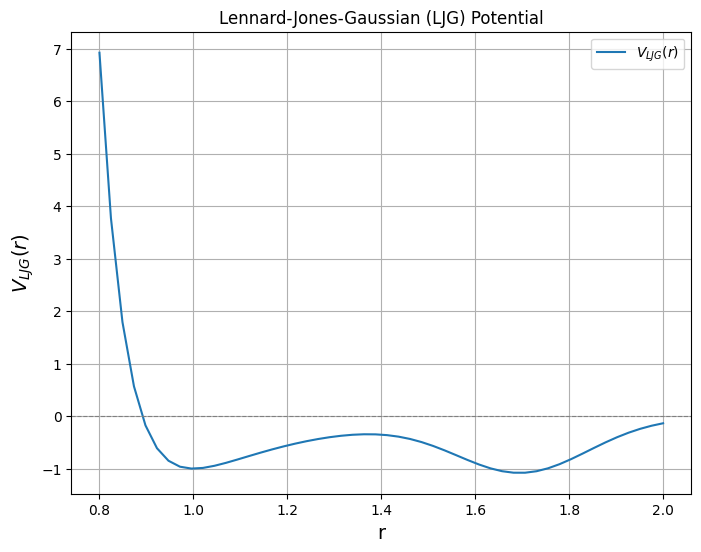

In [646]:
epsilon = 1 # depth of LJ minimum
r0 = 1 # location of LJ minimum
sigma_squared = 0.02 * r0**2 # width of Gaussian
r = np.linspace(0.8,2.0) # 

V_LJG = epsilon * ( (r0/r)**12 -2 * (r0/r)**6 - np.exp (- (r - 1.7 * r0)**2 / (2* sigma_squared)) )

plt.figure(figsize=(8, 6))
plt.plot(r, V_LJG, label=r'$V_{LJG}(r)$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('r', fontsize=14)
plt.ylabel(r'$V_{LJG}(r)$', fontsize=14)
plt.title('Lennard-Jones-Gaussian (LJG) Potential')
plt.grid(True)
plt.legend()
plt.show()

In [647]:
class LennardJonesGauss():
    def __init__(self,eps=1):
        self.eps = eps
        
    def _V(self,r):
        epsilon = self.eps
        return V_LJG
    

    def _dV_dr(self, r):
        epsilon = self.eps
        deriv_V = 42 #dV/dr
        return deriv_V

    
    def _pairwise_distance_matrix(self, pos, box):
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
        for dim in range(2):  # Loop over x and y dimensions and get smallest component
            diff[..., dim] -= np.rint(diff[..., dim] / box[dim, dim]) * box[dim, dim]
        return diff
    
    def energy(self, pos, box):
        diff = self._pairwise_distance_matrix(pos, box)
        r = np.sqrt(np.sum(diff**2, axis=-1))
        return np.sum(self._V(squareform(r)))
    
    def forces(self, pos, box):
        diff = self._pairwise_distance_matrix(pos, box)
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, 1000)
        force_magnitude = self._dV_dr(r)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / \
                        r[..., np.newaxis], axis=1)
        return forces

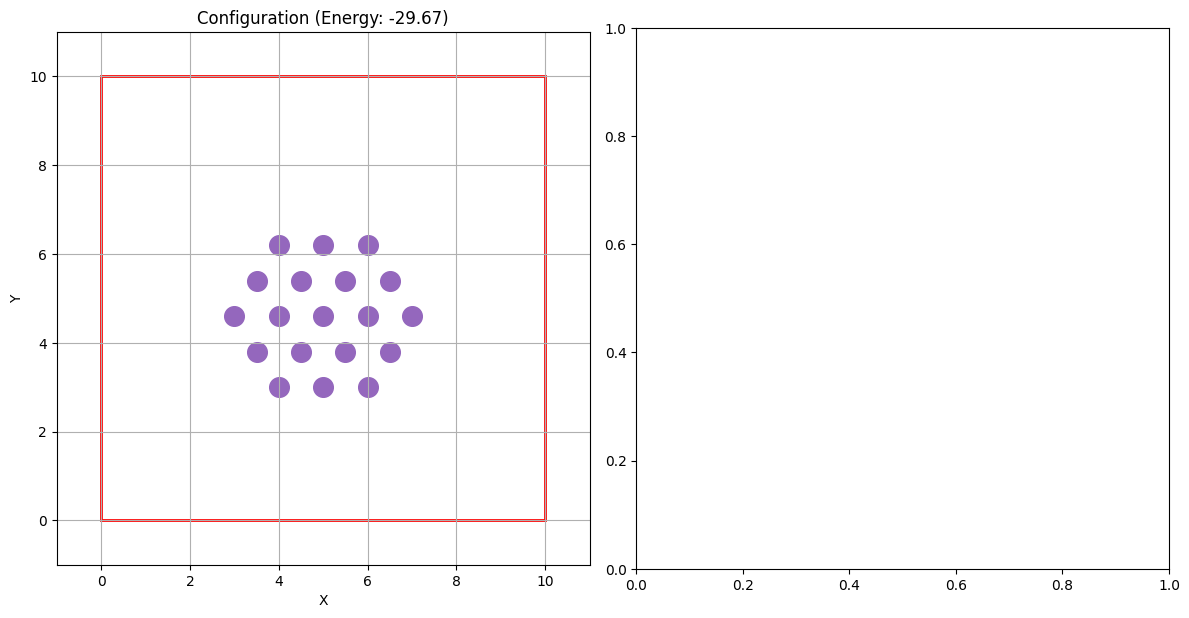

In [648]:
pos = np.array([
    [4, 3],  # Atom 1
    [5, 3],  # Atom 2
    [6, 3],  # Atom 3
    [3.5, 3.8],  # Atom 4
    [4.5, 3.8],  # Atom 5
    [5.5, 3.8],  # Atom 6
    [6.5, 3.8],  # Atom 7
    [3, 4.6],  # Atom 8
    [4, 4.6],  # Atom 9
    [5, 4.6],  # Atom 10
    [6, 4.6],  # Atom 11
    [7, 4.6],  # Atom 12
    [4.5, 5.4],  # Atom 13
    [5.5, 5.4],  # Atom 14
    [4, 6.2],  # Atom 15
    [5, 6.2],  # Atom 16
    [6, 6.2],  # Atom 17
    [3.5, 5.4],
    [6.5, 5.4]
])

box = np.array([[10.0, 0.0], [0.0, 10.0]])

lj = PeriodicLennardJones(eps=1)

energy  = lj.energy(pos_initial, box)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax1 = axes[0]
atomic_cluster.draw(pos, ax1, box_size=10.0)
ax1.set_title(f"Configuration (Energy: {energy:.2f})")

plt.tight_layout()
plt.show()
